# Fast Upsampling in a Single Forward Pass with FeatUp (JBU)

> ⚠️ Change your collab runtime to T4 GPU before running this notebook

In this notebook we will walk through how to load and work with our catalog of pre-trained upsamplers that work with common vision backbones such as CLIP, DINO, DINO v2, and ResNet50. We note that we add a Layer Norm operation to each of these backbones prior to upsampling so keep this in mind if you are trying to replace an existing component with one of our upsampled variants. This is controlled by the `use_norm=True` flag.

In [1]:
!git clone https://github.com/mhamilton723/FeatUp

fatal: destination path 'FeatUp' already exists and is not an empty directory.


## Install FeatUp and our fast Joint Bilateral Upsampling (JBU) Kernel

> ⚠️ This cell will take 3-5 minutes to run because of cuda kernel compilation


In [2]:
import os
os.chdir("FeatUp/")

This cell will take almost 5-8 minutes to run.
If this cell give warning of restart, then please run all cells once again. It will work then.

In [3]:
!pip install -e .
!pip install git+https://github.com/mhamilton723/CLIP.git

Obtaining file:///content/FeatUp
  Preparing metadata (setup.py) ... done
  Attempting uninstall: featup
    Found existing installation: featup 0.1.2
    Uninstalling featup-0.1.2:
      Successfully uninstalled featup-0.1.2
  Running setup.py develop for featup
  Cloning https://github.com/mhamilton723/CLIP.git to /tmp/pip-req-build-_3_bidb1
  Running command git clone --filter=blob:none --quiet https://github.com/mhamilton723/CLIP.git /tmp/pip-req-build-_3_bidb1
  Resolved https://github.com/mhamilton723/CLIP.git to commit dce9d43cc659cb9a013745b378c78077fde6aac0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369791 sha256=53cbcf2c6a624d96e048c6fb8dae300437ebc0694d651532952bf0a5ce2e6a10
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnycsjx7/wheels/b2/8f/fd/d49d1136360818931e323ea3847e852991997fdceda1577f0d
Successfully built clip


In [4]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

Put the image path in the image_path="__"  and then Run the cell

In [5]:
input_size = 224
image_path = "/content/cropped_image_ts1_0_0.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True

transform = T.Compose([
    T.Resize(input_size),
    T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    norm
])

image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

## DINO

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mhamilton723/FeatUp/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/din

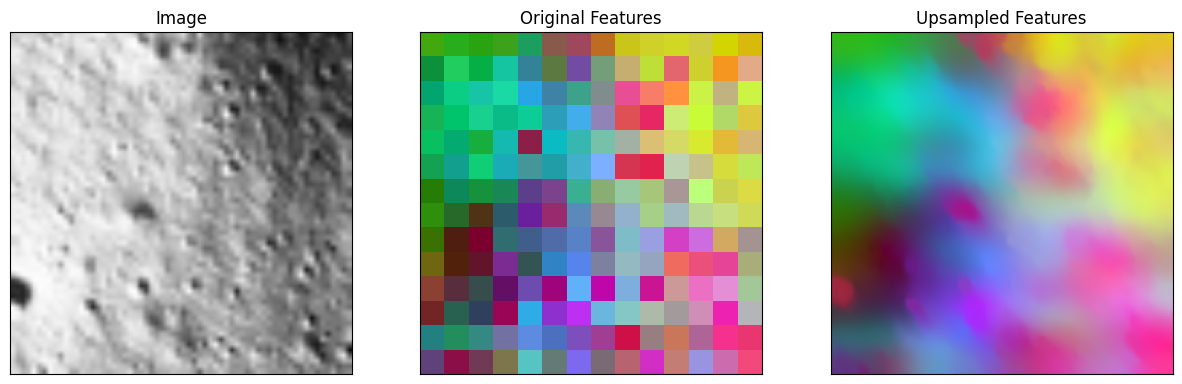

In [6]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

## DINO v2

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/content/FeatUp/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/content/FeatUp/featup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/content/FeatUp/featup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)


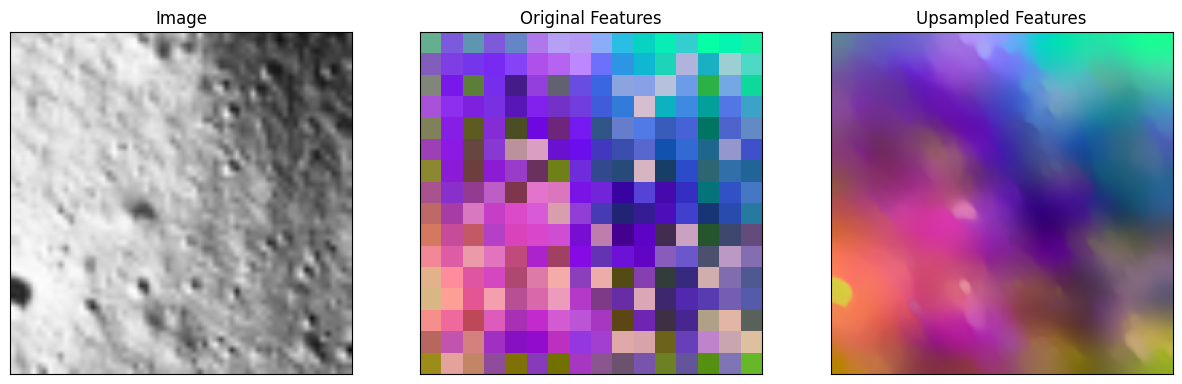

In [7]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

## CLIP

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 194MiB/s]
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/clip_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/clip_jbu_stack_cocostuff.ckpt
100%|██████████| 3.35M/3.35M [00:00<00:00, 8.23MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


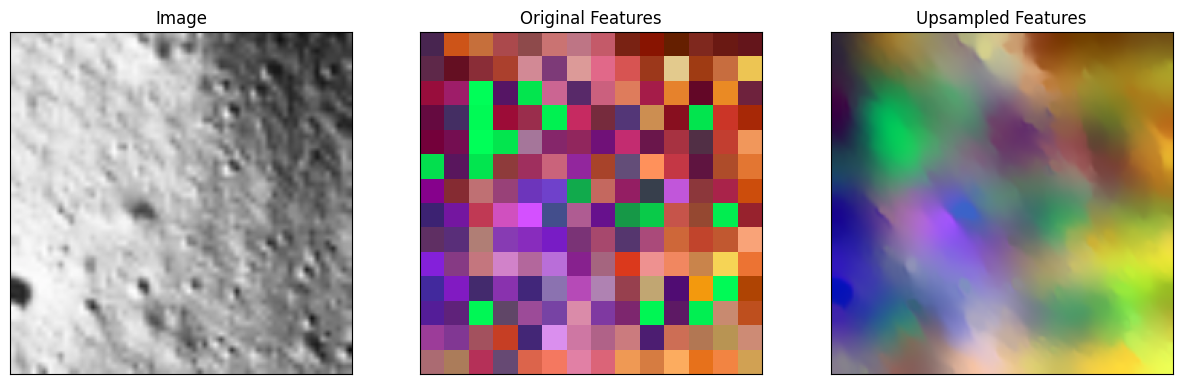

In [8]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'clip', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# MaskCLIP
## Note: Use this version of CLIP for text alignment

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/no_norm/maskclip_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/maskclip_jbu_stack_cocostuff.ckpt
100%|██████████| 3.35M/3.35M [00:00<00:00, 7.80MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


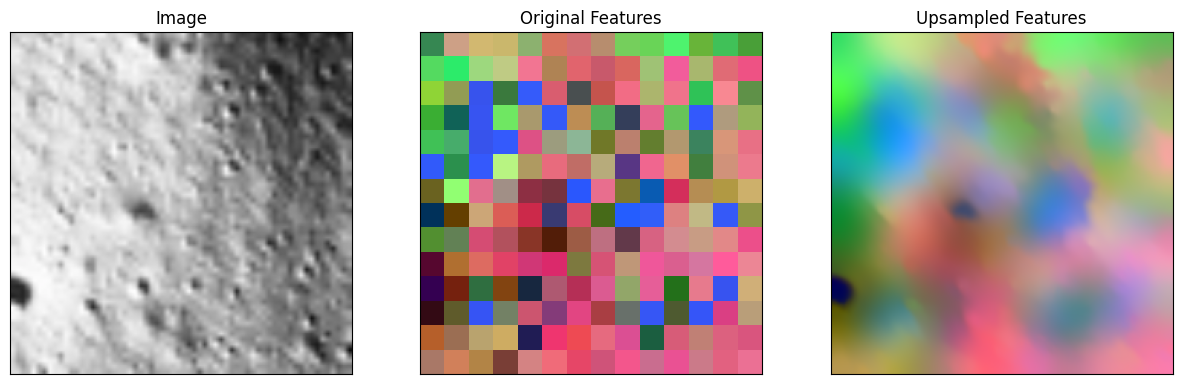

In [9]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'maskclip', use_norm=False).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ViT

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/vit_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/vit_jbu_stack_cocostuff.ckpt
100%|██████████| 2.04M/2.04M [00:00<00:00, 4.87MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


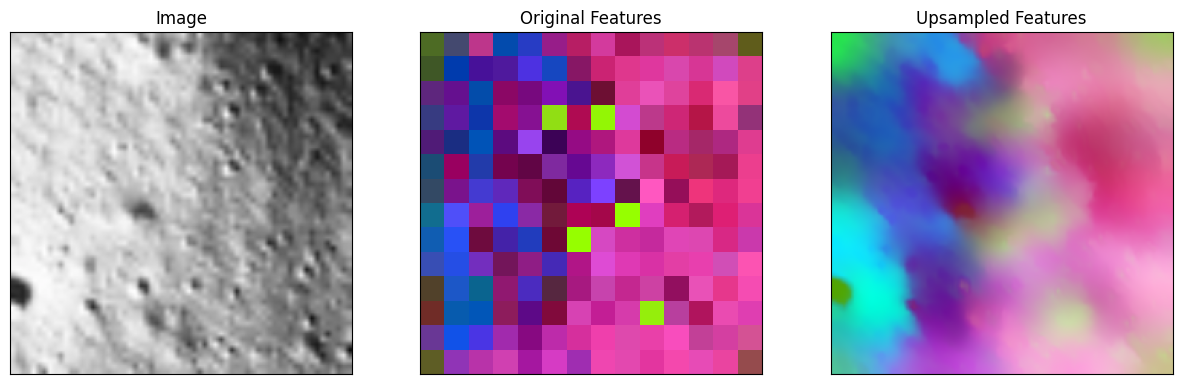

In [10]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'vit', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ResNet 50

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/resnet50_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/resnet50_jbu_stack_cocostuff.ckpt
100%|██████████| 48.4M/48.4M [00:01<00:00, 33.9MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


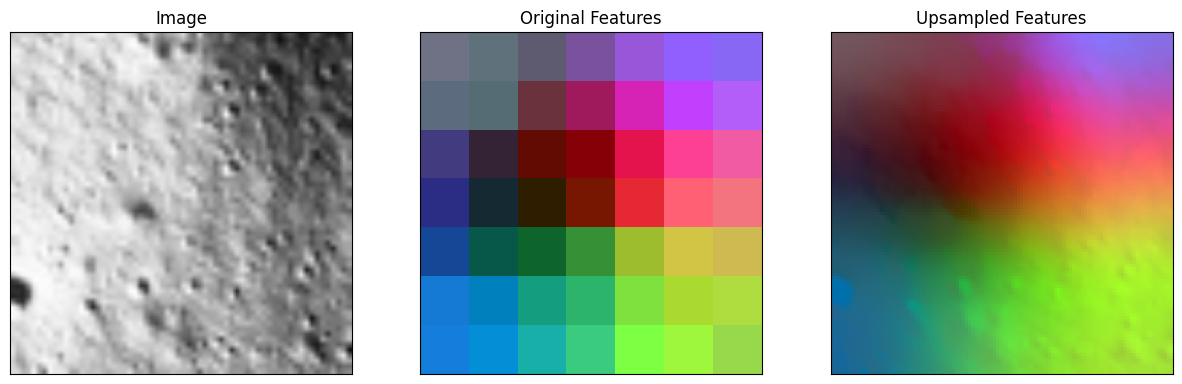

In [11]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'resnet50', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

INFO:lightning_fabric.utilities.seed:Seed set to 0


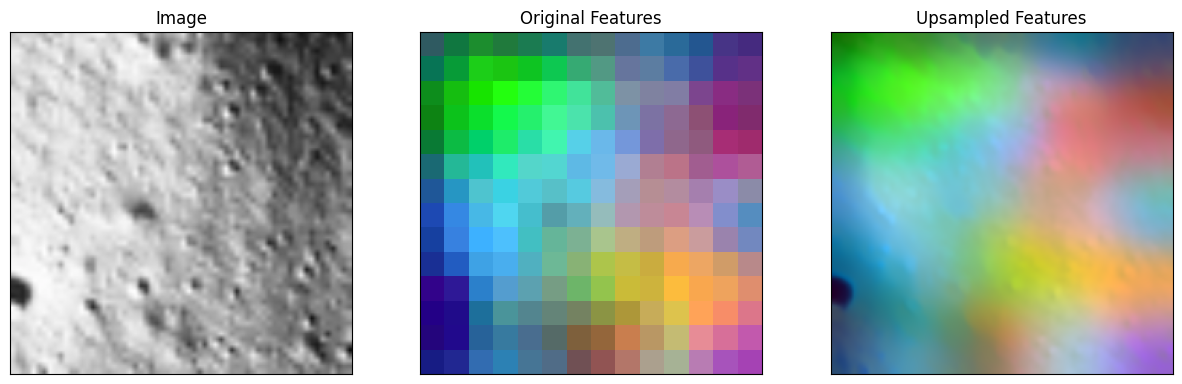

In [12]:
import torch.nn.functional as F

big_img = F.interpolate(image_tensor, scale_factor=2, mode='bilinear')
hr_feats = upsampler(big_img)
lr_feats = upsampler.model(big_img)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])